# Animating fluids with DeltaFlow

DeltaFlow can take advantage of a GPU to render high-resolution fluid simulations at hundreds of frames per second. This notebook is quick overview of how to set up, run, and visualize simulations.

## Setup

We'll start by importing `deltaflow` and supporting libaries.

In [1]:
# Clone DeltaFlow and install
!git clone https://github.com/VKG5/Simulaton.git
!pip install ./Simulaton

import deltaflow

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow

# Matplotlib formatting
from matplotlib import rc
rc("animation", html="html5", bitrate=-1)

fatal: destination path 'Simulaton' already exists and is not an empty directory.
Processing ./Simulaton
  Created wheel for DeltaFlow: filename=DeltaFlow-1.0-cp37-none-any.whl size=6525 sha256=58a788782ae751529722718d4d68af658c2a60a0af45e5e9937cc7457dde2ebf
  Stored in directory: /tmp/pip-ephem-wheel-cache-ux2ouc5o/wheels/67/2d/1f/9e5e1b1ab47ba3e94ea6e23ad4b224e82672395fcc7b89fffa
Successfully built DeltaFlow
  Found existing installation: DeltaFlow 1.0
    Uninstalling DeltaFlow-1.0:
      Successfully uninstalled DeltaFlow-1.0


## Simulation parameters

First, we'll set up the simulation's physical parameters, which determine properties like fluid density and time resolution.

In [2]:
# One limitation is that it only works for square matrices/resolution sizes for now
x_resolution = 720
y_resolution = 720
timesteps = 450

simulation_config = deltaflow.SimulationConfig(
    delta_t=0.1,  # Time elapsed in each timestep.
    density_coeff=1.0,  # Fluid density. Denser fluids care respond to pressure more slowly.
    diffusion_coeff=1e-3,  # Diffusion coefficient. Higher values cause higher diffusion and viscosity.
)

## Initial conditions

Then we'll define the initial conditions. These can include:
 - Colored dye in the fluid to visualize flow.
 - An initial velocity at each location in the fluid.
 - External force to apply at each timestep.
 
Here, we'll add a red checkerboard dye, and start with a swirly velocity pattern. We won't use an external force.

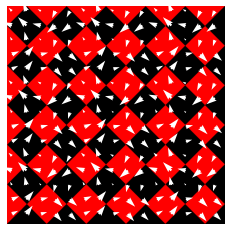

In [3]:
# Initialize the colors to a checkerboard pattern
color = np.zeros((y_resolution, x_resolution, 3))
y_wave = np.sin(np.linspace(-5.5 * np.pi, 5.5 * np.pi, num=y_resolution))
x_wave = np.sin(np.linspace(-5.5 * np.pi, 5.5 * np.pi, num=x_resolution))
color[:, :, 0] = (x_wave[np.newaxis, :] + y_wave[:, np.newaxis] + 2) / 4 > 0.5

# Initialize the velocity to a swirly pattern
velocity = np.zeros((y_resolution, x_resolution, 2))
velocity[:, :, 1] = (
    np.sin(np.linspace(-3 * np.pi, 3 * np.pi, x_resolution))[:, np.newaxis] * 30
)
velocity[:, :, 0] = (
    np.sin(np.linspace(-3 * np.pi, 3 * np.pi, y_resolution))[np.newaxis, :] * 30
)

# Visualize the initial conditions. 
# `velocity` is optional here, and leaving it off will just visualize the color field.
deltaflow.utils.draw_frame(color, velocity)
print()

## Running a simulation

Now for the fun part! `simulate()` takes in some initial conditions and outputs a stack of frames, which are just numpy arrays.
The simulation runs on the GPU, so it should be quite fast even for high resolutions.

In addition to making frame animations, the `simulate()` API can also produce final conditions that support taking gradients through the whole simulation process. See the Optimization notebook for an example of this use. 

In [4]:
color_frames, velocity_frames = deltaflow.simulate(
    timesteps, color, velocity, config=simulation_config
)

Simulating: 100%|██████████| 450/450 [07:29<00:00,  1.00frame/s]


(450, 720, 720, 3)


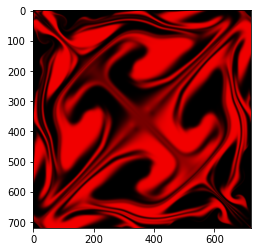

In [5]:
plt.imshow(color_frames[175])
print(color_frames.shape)

## Displaying and saving animations

`deltaflow.utils` includes some utilities for drawing and animating frames:
  - `draw_frame` (above) displays the color field and, optionally, the velocity field.
  - `animate_frames` is similar to `draw_frame`, but produces a matplotlib animation out of multiple frames.
  - `write_video` saves a stack of color frames to a video.

In [6]:
# deltaflow.utils.animate_frames(color_frames)

# You can also include the velocity field in the animation:
deltaflow.utils.animate_frames(color_frames, velocity_frames)

In [7]:
deltaflow.utils.write_video("./swirly_vectors_720.mp4", color_frames)